#Unit 8 Project: How Does Economic Uncertainty Impact World Happiness?

For this project, I decided to use a dataset of the world happiness index. (Thanks to Jette for the dataset suggestion) With my project and BART model, I am attempting to find out whether or not economic uncertainty values can affect a country's happiness. I was inspired to answer this question by the current economic situation our country is facing.

To accomplish this, I am using a BART model to find whether certain recessionary economic indicators be used as predictors for happiness.

In [7]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
url="https://raw.githubusercontent.com/jettecampbell/data-science/refs/heads/main/WHI_Inflation.csv"
WHI = pd.read_csv(url).dropna()

Since the study also includes regions within countries, it was recommended to me that converting each region into an integer would benefeit the study because they could be used as posterior predictors.

In [8]:
WHindex = pd.DataFrame(columns = ['', ' '])


WHindex['Continent/Region'] = pd.Categorical(WHI['Continent/Region'])


region_idx = WHindex['Continent/Region'].cat.codes.values


region_codes = WHindex['Continent/Region'].cat.categories


region_coords = {"Continent/Region": region_codes}

WHI['Region'] = region_idx

In [9]:
region_idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9,
       9, 9, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

The predictors I chose to answer this question are all currently headed in the wrong direction as we inch closer to a recession. Those predictors are Producer Price Inflation, GDP deflator Index growth rate, Consumer Price Inflation, GDP per Capita. These predictors will join my region predictor showcased above.

In [13]:
values = ["Region","Producer Price Inflation", "GDP deflator Index growth rate", "GDP per Capita", "Official Core Consumer Price Inflation"]

X = WHI[values]
Y = WHI["Score"].to_numpy()

In [14]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

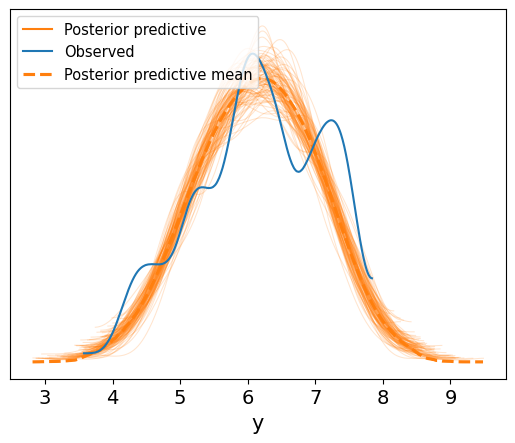

In [15]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

The posterior Predictive curve fit the data very well despite a couple of curves going outside the range. Even with the Harsher curves at either end, I believe that this data fits well enough to avoid refitting.

In [17]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

In [18]:
Xn = X.to_numpy()

My next idea was to find the predictor that was most frequently reported on and create an HDI model to measure how it alone impacts happiness. For this task, I chose GDP per capita as products will soon become much more expensive due to the threat of high tariffs on other countries' goods which could cause citizens to have less money than before.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


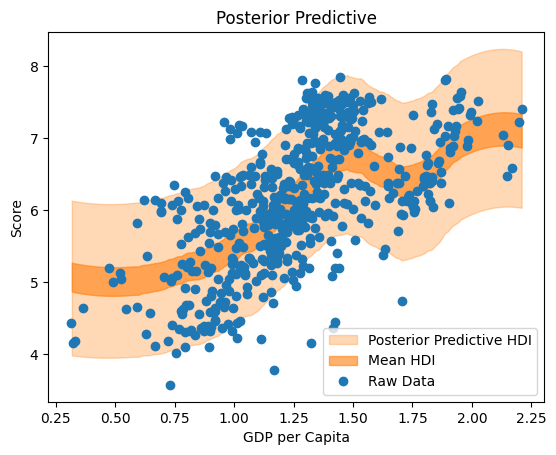

In [20]:
idx = np.argsort(Xn[:, 3])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 3],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 3],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(WHI["GDP per Capita"], WHI["Score"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="GDP per Capita",
    ylabel="Score",
);

The data correlated with the prediction very well. This is relatively obvious as countries with high GDPpc are on average happier. Next, I decided to compare all 5 predictors with a pdp and ice plot.

array([<Axes: xlabel='Region'>, <Axes: xlabel='Producer Price Inflation'>,
       <Axes: xlabel='GDP deflator Index growth rate'>,
       <Axes: xlabel='GDP per Capita'>,
       <Axes: xlabel='Official Core Consumer Price Inflation'>],
      dtype=object)

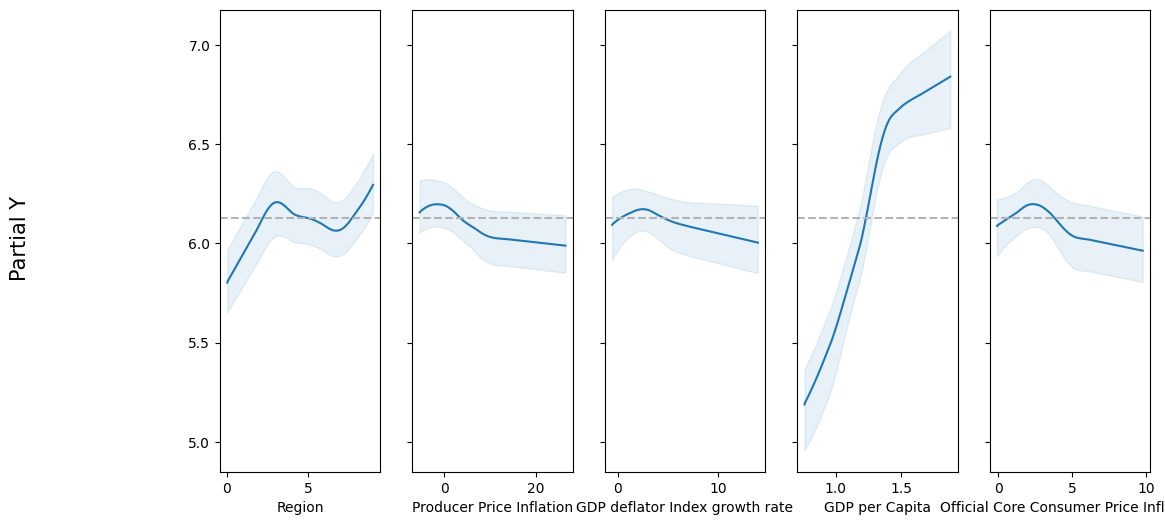

In [21]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='Region'>, <Axes: xlabel='Producer Price Inflation'>,
       <Axes: xlabel='GDP deflator Index growth rate'>,
       <Axes: xlabel='GDP per Capita'>,
       <Axes: xlabel='Official Core Consumer Price Inflation'>],
      dtype=object)

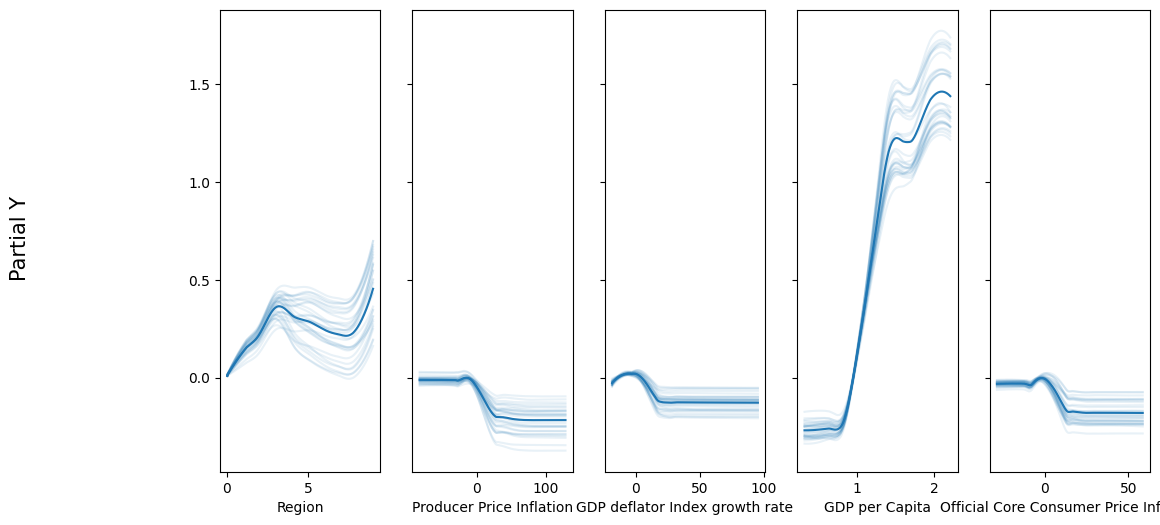

In [22]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

I was suprised to find that none of my predictors other than GDPpc correlated much with the WHI. While they do drop off once the value exceeds zero, the drop is'nt nearly as steep or severe as GDPpc appears to be. After this realization, I will create a pmb plot to determine each preictor's incluence on my BART model.

In [23]:
vi_WHI = pmb.compute_variable_importance(idata_octps, μ_, X)

<Axes: ylabel='R²'>

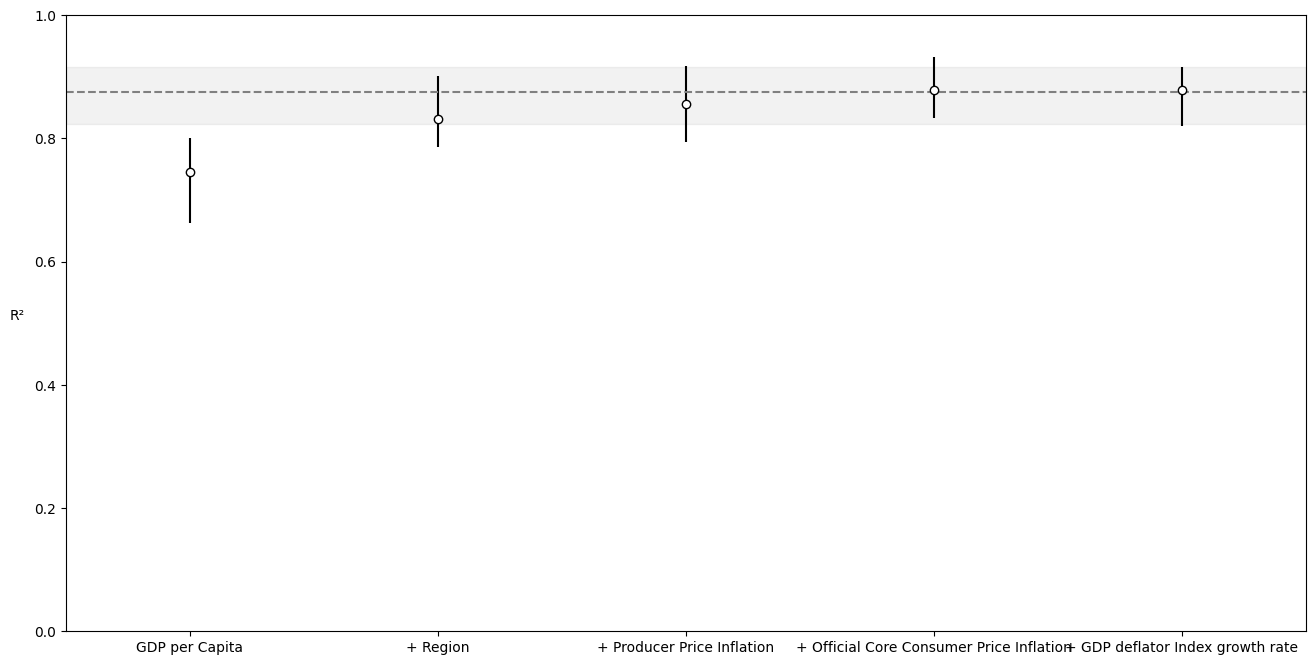

In [24]:
pmb.plot_variable_importance(vi_WHI, figsize = (16,8))

After testing economic indicators and their impact to world happiness, I have found that the happiness of a nation's citizens isn't correlated to the success of the economy at large and really only correlates with one's personal economic standing. I can't really say I'm suprised by these findings as many of my predictors such as GDP deflator is more of an implicit prediction for how bad inflation will rise in the future rather than a concrete number that affects citizens' day-to-day lives. The conclusion of my project also serves to underscore how, even though our economy may seem bleak right now, there are always other aspects of our individual lives that will impact our happiness more than the whole US economy.